In [94]:
from typing import Iterable

import sys
sys.path.append("/scratch/gf332/BayesOpt/boa/scripts")

import os
import logging

import time

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from stheno.tensorflow import GP, EQ, Delta, Graph, Matern52
from stheno.tensorflow import Graph

import numpy as np
import matplotlib.pyplot as plt

from boa.models.random import RandomModel
from boa.models.fully_factorized_gp import FullyFactorizedGPModel
from boa.models.gpar import GPARModel
from boa.models.matrix_factorized_gpar import MatrixFactorizedGPARModel
from boa.models.svd_gpar import SVDFactorizedGPARModel
from boa.models.gpar_perm import PermutedGPARModel

from boa.core.distribution import GumbelMatching
from boa.core.utils import tensor_hash

from boa.core.kernel import DiscreteEQ, DiscreteMatern52, PermutationEQ, perm_pointwise_distance

from boa.core.gp import GaussianProcess, DiscreteGaussianProcess
from boa.core.utils import inv_perm, calculate_euclidean_distance_percentiles

from not_tf_opt import map_to_bounded_interval, map_from_bounded_interval

from sklearn.model_selection import train_test_split
from itertools import permutations

import functools

from not_tf_opt import BoundedVariable, AbstractVariable, get_reparametrizations, UnconstrainedVariable

import seaborn as sns

import pandas as pd

save_dir = "../plots/notebook_plots/scratch/"

In [95]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [128]:
gemm_df = pd.read_csv("/scratch/gf332/BayesOpt/boa/resources/gemm_dataset_v2.csv")
stencil_df = pd.read_csv("/scratch/gf332/BayesOpt/boa/resources/stencil3d_dataset_v2.csv")

In [129]:
gemm_df = gemm_df.rename({"avg_power (mW) ": "avg_power", "total_area (uM^2)": "total_area"}, axis=1)

In [130]:
stencil_df = stencil_df.rename({"avg_power (mW) ": "avg_power", "total_area (uM^2)": "total_area"}, axis=1)

In [110]:
gemm_df.columns = stencil_df.columns

In [131]:
stencil_df.to_csv("/scratch/gf332/BayesOpt/boa/resources/stencil3d_dataset_v2.csv", index=False)

In [132]:
gemm_df.to_csv("/scratch/gf332/BayesOpt/boa/resources/gemm_dataset_v2.csv", index=False)

$$
 M = LR
$$

$$
(aL, \frac{R}{a})
$$

$$
    M = a \frac{L}{||L||} \frac{R}{||R||}
$$

$$
(a, L, R), (a, LO, O^{\top}R)
$$

$$
    M = U\Sigma V^{\top}
$$

$$
    UU^{\top} - I = \mathbf{0}
$$

$$
    \ell + ||UU^{\top} - I||^2 + ||VV^{\top} - I||^2
$$

In [119]:
tfl = tf.linalg

def householder_reflector(v, dim, as_matrix=False):

        if isinstance(v, AbstractVariable):
            v = v()

        v = tf.convert_to_tensor(v, dtype=tf.float64)

        if tf.rank(v) > 1:
            raise ValueError(f"v must be rank 1, but had shape {v.shape}!")

        v_len = v.shape[0]

        if v_len > dim:
            raise ValueError(f"The dimension of v must be less than dim ({dim}), but was {v_len}!")

        reflector = tfl.LinearOperatorBlockDiag([tfl.LinearOperatorIdentity(num_rows=dim - v_len, dtype=v.dtype),
                                                 tfl.LinearOperatorHouseholder(v)])

        if as_matrix:
            reflector = reflector.to_dense()

        return reflector

In [125]:
u_4 = tf.random.uniform((4,), -10., 10., dtype=tf.float64)
u_3 = tf.Variable(tf.random.uniform((3,), -10., 10., dtype=tf.float64))
u_2 = tf.Variable(tf.random.uniform((2,), -10., 10., dtype=tf.float64))
u_1 = tf.Variable(tf.random.uniform((1,), -10., 10., dtype=tf.float64))

with tf.GradientTape() as tape:
    orth = tfl.LinearOperatorComposition([
        householder_reflector(u_1, 4),
        householder_reflector(u_2, 4),
        householder_reflector(u_3, 4),
        householder_reflector(u_4, 4)]).to_dense()

tape.jacobian(orth, u_3)[..., 0]

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.06784908, -0.04193659,  0.10744915,  0.01994879],
       [-0.06463703, -0.05997995,  0.03253298, -0.08148031],
       [ 0.02765525,  0.0256627 , -0.01391939,  0.03486172]])>

In [83]:
householder_reflector(u_4, 4)

array([[-0.55470949,  0.81958644, -0.10880129, -0.09347587],
       [ 0.81958644,  0.56794377,  0.0573561 ,  0.04927709],
       [-0.10880129,  0.0573561 ,  0.99238589, -0.00654161],
       [-0.09347587,  0.04927709, -0.00654161,  0.99437983]])

In [13]:
def ordered_reparam(y):
    x0 = y[..., :1]
    xk = y[..., 1:]
    x = tf.concat([x0, xk], axis=-1)
    return tf.cumsum(x, axis=-1)

In [4]:
gpar = GPARModel.restore("../models/fft/pred/20200414-114325/size_50/model_0/model")

In [6]:
gpar_ls = gpar.length_scales()

In [66]:
ls_init, _, _ = gpar.create_all_hyperparameter_initializers(length_scale_init_mode="l2_median")

In [67]:
def get_ls_mat(ls_list):
    input_ls = []
    output_ls = []

    for ls in ls_list:
        input_ls.append(ls()[:gpar.input_dim])
        output_ls.append(ls()[gpar.input_dim:])

    input_ls = tf.stack(input_ls, axis=0)
    
    return input_ls, output_ls

In [68]:
input_ls, output_ls = get_ls_mat(gpar_ls)
init_input_ls, _ = get_ls_mat(ls_init)

In [90]:
latent_dim = 10
lower = 1e-8
upper = 1000.

input_ls_rep = map_from_bounded_interval(input_ls, lower, upper)

s, u, v = tf.linalg.svd(input_ls_rep, compute_uv=True, full_matrices=False)

low_rank_ils = tf.einsum('nd, d, md -> nm', u[:, :latent_dim], s[:latent_dim], v[:, :latent_dim])

low_rank_ils = map_to_bounded_interval(low_rank_ils, lower, upper)

tf.reduce_max(tf.abs(low_rank_ils - input_ls))

<tf.Tensor: shape=(), dtype=float64, numpy=312.2650968170641>

In [91]:
new_input_ls_mat = low_rank_ils

new_ls = []

for ils, ols in zip(new_input_ls_mat, output_ls):
    new_ls.append(UnconstrainedVariable(tf.concat([ils, ols], axis=0)))

In [92]:
gpar.log_prob(gpar.xs, gpar.ys, predictive=False, length_scales=new_ls, average=True)

<tf.Tensor: shape=(), dtype=float64, numpy=15.07176643077255>

In [11]:
!ls ../models/fft/pred/20200414-114325/size_50

model_0  model_1  model_2  model_3  model_4


In [13]:
!ls ../logs/fft/pred/svd-gpar-5/

20200430-142716  20200502-130132  20200504-161616  20200505-222639
20200430-142853  20200502-130348  20200504-162207  20200505-222658
20200430-143028  20200502-130831  20200504-162858  20200505-222729
20200430-143422  20200502-163229  20200504-163247  20200505-223002
20200430-144128  20200502-163621  20200504-163835  20200505-223152
20200430-152024  20200502-165944  20200504-164219  20200505-223234
20200430-152049  20200504-154456  20200504-172337  20200505-223409
20200430-165133  20200504-155124  20200504-174152  20200505-223519
20200430-175549  20200504-155834  20200505-222132  20200505-223547
20200430-175811  20200504-160931  20200505-222349  20200505-223653
20200430-181051  20200504-161333  20200505-222549  20200505-223734


In [3]:
svd_gpar = SVDFactorizedGPARModel.restore("../models/fft/pred/20200505-223734/size_25/model_0/model")

Instructions for updating:
Do not call `graph_parents`.


In [4]:
svd_gpar.singular_values

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([5., 4., 3., 2., 1.])>

<BarContainer object of 15 artists>

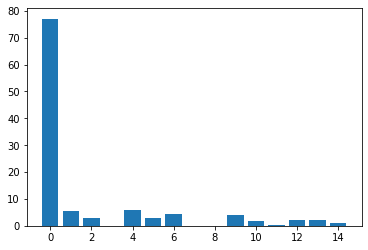

In [7]:
plt.bar(range(15), svd_gpar._singular_values().numpy())

In [5]:
model = GPARModel.restore("../models/fft/pred/20200418-113422/size_200/model_1/model")#
#model = FullyFactorizedGPModel.restore("../models/fft/pred/20200325-180355/size_100/model_1/model")

In [6]:
model.initialize_hyperpriors("l2_median")

27/04/2020 01:32:04 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 0
27/04/2020 01:32:04 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 1
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 2
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 3
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 4
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 5
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 6
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 7
27/04/2020 01:32:05 PM:INFO:boa.models.multi_output_gp_regression_model:Calculating statistics for GP 8
27/04/2020 01:32:06 PM:INFO:boa.models.multi_output_gp_regressio

In [7]:
model.log_prob(model.xs, model.ys, predictive=False, joint=True)

<tf.Tensor: shape=(), dtype=float64, numpy=462.20485446198904>

$$
    \log p(x \mid z) + \sigma KL(q || p)
$$

$$
    \argmin f(x)
$$

In [8]:
def joint_log_prob(sas, lss, nas):
    
    length_scale_index = 0
    
    sa_list = []
    ls_list = []
    na_list = []
    
    for i in range(model.output_dim):
        sa_list.append(sas[i:i + 1])
        na_list.append(nas[i:i + 1])
        ls_list.append(lss[length_scale_index:length_scale_index + i + model.input_dim])
        
        length_scale_index += i + model.input_dim
    
    return model.log_prob(xs=model.xs, 
                           ys=model.ys, 
                           predictive=False, 
                           joint=True,
                           signal_amplitudes=sa_list,
                           length_scales=ls_list,
                           noise_amplitudes=na_list)

In [9]:
joint_log_prob(*[tf.concat([sap.sample() for sap in model.signal_amplitude_priors], axis=0),
                       tf.concat([lsp.sample() for lsp in model.length_scales_priors], axis=0),
                       tf.concat([nap.sample() for nap in model.noise_amplitude_priors], axis=0)],)

<tf.Tensor: shape=(), dtype=float64, numpy=-8527.650368461997>

In [24]:
def sample():
    return tfp.mcmc.sample_chain(
        num_results=50,
        num_burnin_steps=70,
        current_state=[tf.concat([sap.sample() for sap in model.signal_amplitude_priors], axis=0),
                       tf.concat([lsp.sample() for lsp in model.length_scales_priors], axis=0),
                       tf.concat([nap.sample() for nap in model.noise_amplitude_priors], axis=0)],
        kernel=tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.SliceSampler(
                    target_log_prob_fn=joint_log_prob,
                    step_size=tf.constant(1., tf.float64),
                    max_doublings=5,
                ),
                bijector=[
                    tfb.Softplus(),
                    tfb.Softplus(),
                    tfb.Softplus(),
                ]
            ),)

In [25]:
start = time.time()
[post_sa, post_ls, post_na], _ = sample()
end_time = time.time() - start

/scratch/gf332/BayesOpt/venv/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


TypeError: x and y must have the same dtype, got tf.float32 != tf.float64

In [40]:
end_time

1129.1915109157562

In [42]:
post_sa[traces.inner_results.is_accepted]

<tf.Tensor: shape=(49, 15), dtype=float64, numpy=
array([[0.07346908, 0.04975406, 0.10756861, 0.03664653, 0.03771188,
        0.15017867, 0.30221822, 0.27667603, 0.09580823, 0.20767775,
        0.0842806 , 0.19017183, 0.15609167, 0.11516713, 0.31999021],
       [0.08126231, 0.04424648, 0.10581955, 0.03905608, 0.03855922,
        0.15022088, 0.26642283, 0.25716851, 0.09081238, 0.19271122,
        0.09894129, 0.18149612, 0.15770057, 0.13802299, 0.29671859],
       [0.08988406, 0.04579226, 0.09260782, 0.04416516, 0.03834458,
        0.15454349, 0.26206839, 0.28413697, 0.08054257, 0.19810686,
        0.08893166, 0.21799601, 0.16449931, 0.147514  , 0.30556164],
       [0.09638162, 0.05043785, 0.08009071, 0.0441902 , 0.03938459,
        0.14389684, 0.27365792, 0.26500331, 0.08023168, 0.1968475 ,
        0.09211282, 0.2007853 , 0.15105028, 0.11757953, 0.29582008],
       [0.08688796, 0.04531758, 0.08078507, 0.04209778, 0.04071607,
        0.14564617, 0.2487996 , 0.26354487, 0.07451368, 0.2032

In [41]:
tfp.mcmc.effective_sample_size(post_sa[traces.inner_results.is_accepted])

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([11.2014025 ,  9.92558334,  8.72354551, 16.52661066, 15.51992197,
        7.81497002, 10.50156972,  5.73676601,  7.33397921,  6.39899781,
       14.64625268, 16.14478607, 15.47316975,  8.77857748,  5.82791991])>

In [277]:
ind = 2

joint_log_prob(post_sa[ind], post_ls[ind], post_na[ind], add_prior=False)

<tf.Tensor: shape=(), dtype=float64, numpy=-641.3176719668978>

In [54]:
ind=0

n = tfd.InverseGamma(2., 2.)
xs = np.linspace(0., 10., 50)
plt.hist(post_ls[traces.is_accepted][:, ind], bins=20)
plt.plot(xs, n.prob(xs))

NameError: name 'post_ls' is not defined

In [235]:
pl = tfd.PlackettLuce(scores=[1, 2, 3])

pl.sample()

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 0], dtype=int32)>

In [56]:
input_length_scales = []

for i in range(model.output_dim):
    joint_ls = model.length_scales(i)()
    
    input_length_scales.append(joint_ls[:model.input_dim])
   
# Input length scale matrix
ils_mat = tf.stack(input_length_scales, axis=0)

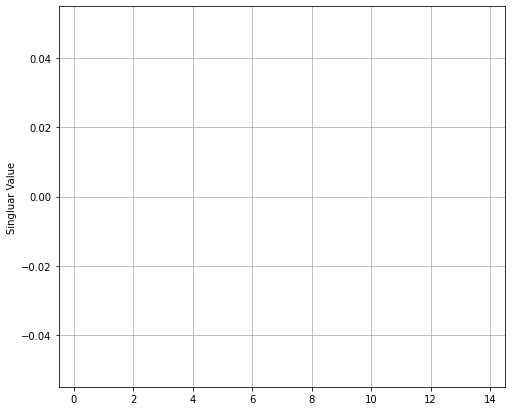

In [57]:
singular_vals = tf.linalg.svd(ils_mat, compute_uv=False)[1:]
plt.figure(figsize=(8, 7))
plt.scatter(np.arange(1, len(singular_vals) + 1), singular_vals.numpy(), c='g', marker='x')
plt.xlim([-0.5, 14.5])
plt.grid('on')
plt.ylabel("Singluar Value")
plt.savefig("singluar_values.png")
plt.show()

In [4]:
train_perm = tf.convert_to_tensor(train_permutations)
train_perm = tf.cast(train_perm, tf.float64)

train_lp = tf.convert_to_tensor(train_log_probs)
train_lp = tf.cast(tf.reshape(train_lp, [-1, 1]), tf.float64)

alpha = tf.Variable(1., dtype=tf.float64)
ls = tf.Variable(1., dtype=tf.float64)
noise_amp = tf.Variable(1e-3, dtype=tf.float64)

kern = KendallTauEQ().stretch(ls)
kern = alpha * kern
noise_kern = noise_amp * Delta()

signal = GP(kern)
noise = GP(noise_kern)

In [5]:
p1, p2 = train_permutations

In [6]:
def spearman_rho(a, b):
    
    n = len(a)
    
    a_inv = inv_perm(a)
    b_inv = inv_perm(b)
    
    numerator = 0
    
    for i in range(n):
        numerator += (a_inv[i] - b_inv[i])**2
        
    return 1 - 6 * numerator / (n * n * n - n)

In [19]:
def generate_dist_1_neighbourhood(perm):
    neighbourhood = []

    for i in range(len(perm) - 1):
        new_perm = list(perm)
        new_perm[i:i + 2] = new_perm[i:i + 2][::-1]

        neighbourhood.append(tuple(new_perm))

    return neighbourhood


def generate_neighbourhood(perm, dist=1):
    neighbourhood = {tuple(perm)}

    for d in range(dist):
        n_p = set([])
        for p in neighbourhood:
            n_p.update(generate_dist_1_neighbourhood(p))

        neighbourhood.update(n_p)

    return list(neighbourhood)

In [53]:
N = 3

candidate_perms = list(permutations(range(N)))

# flatten = lambda l: [item for sublist in l for item in sublist]
# candidate_perms = flatten(list(map(lambda p: generate_neighbourhood(p, dist=2), candidate_perms)))

In [6]:
len(list(set(candidate_perms)))

24

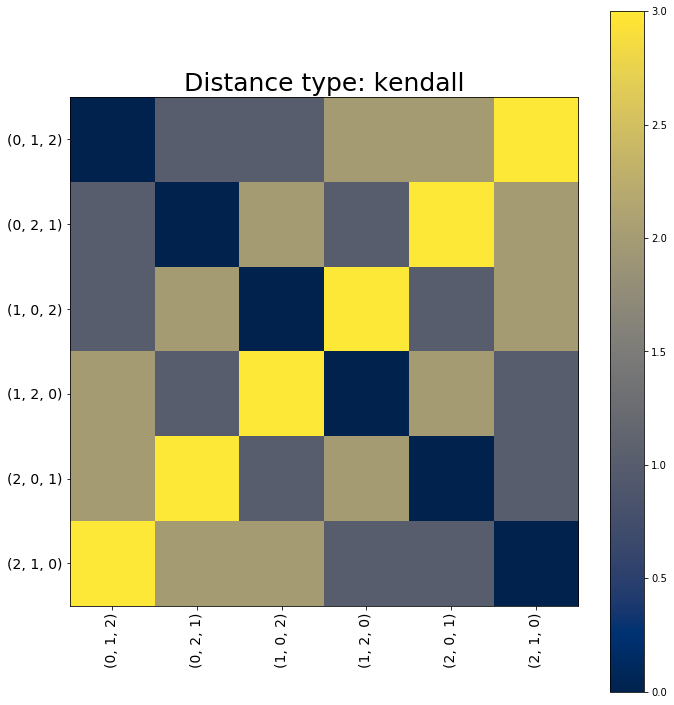

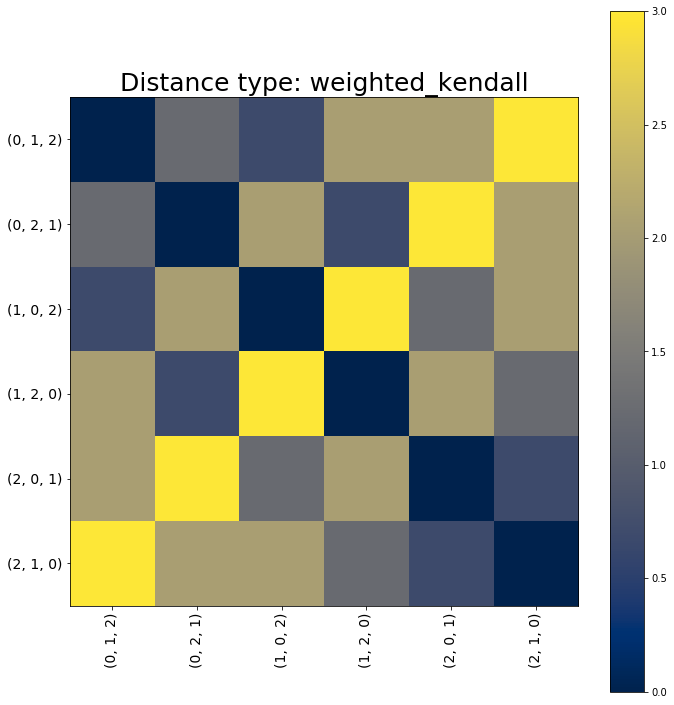

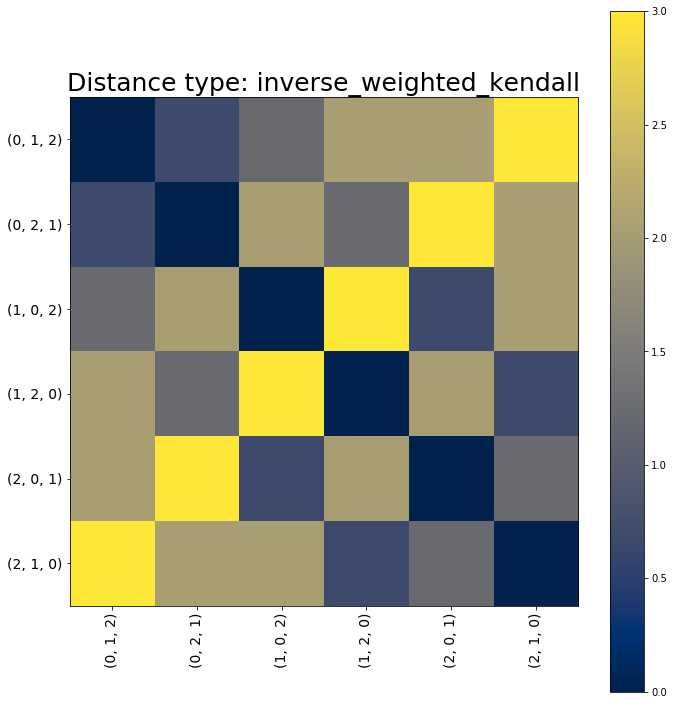

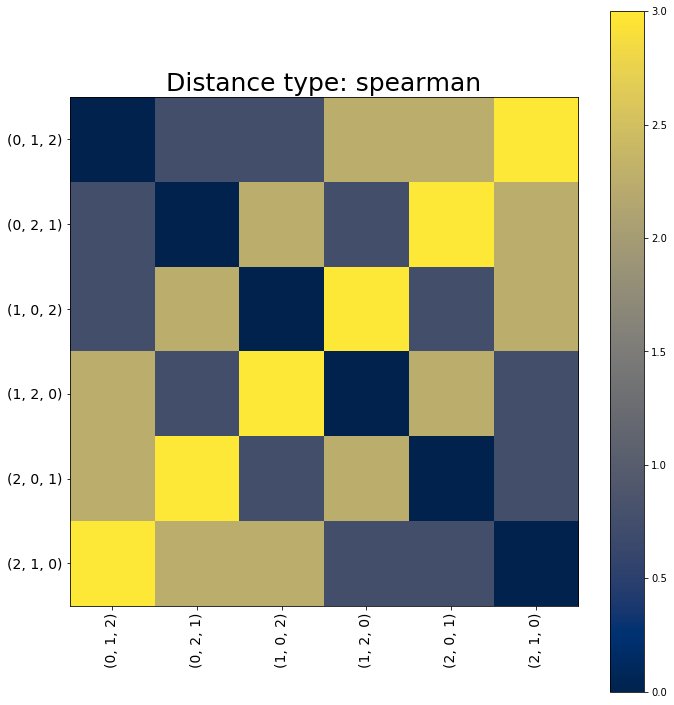

In [54]:
kinds = ["kendall", "weighted_kendall", "inverse_weighted_kendall", "spearman"]

num_perms = len(list(candidate_perms))

for kind in kinds:
    plt.figure(figsize=(10, 10))
    pw_dists = perm_pointwise_distance(tf.convert_to_tensor(candidate_perms, dtype=tf.float32), 
                                          tf.convert_to_tensor(candidate_perms, dtype=tf.float32),
                                          kind=kind) * (N - 1) / 8
    plt.imshow(pw_dists, cmap="cividis")
    plt.xticks(np.arange(num_perms), candidate_perms, rotation=90, fontsize=14)
    plt.yticks(np.arange(num_perms), candidate_perms, fontsize=14)
    plt.title(f"Distance type: {kind}", fontsize=25)
    plt.colorbar()
    plt.tight_layout()
    
    plt.savefig(f"{save_dir}/dist_{kind}_{N}")
    plt.show()
#pw_dists.numpy()

In [8]:
pw_dists = tf.cast(tf.round(pw_dists), tf.int32).numpy()

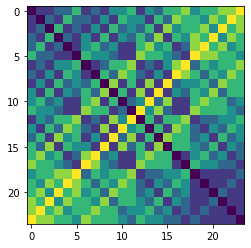

In [12]:
plt.imshow(pw_dists)

In [7]:
pw_dists.tolist()

[[0, 1, 1, 2, 2, 3],
 [1, 0, 2, 1, 3, 2],
 [1, 2, 0, 3, 1, 2],
 [2, 1, 3, 0, 2, 1],
 [2, 3, 1, 2, 0, 1],
 [3, 2, 2, 1, 1, 0]]

In [5]:
candidate_perms

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [9]:
def inv_perm(x):
    inv = [0] * len(x)
    
    for i in range(len(x)):
        inv[x[i]] = i
        
    return tuple(inv)

In [64]:
!ls /scratch/gf332/BayesOpt/boa/models/fft/pred/20200311-154358/size_150/model_0

checkpoint  model.data-00000-of-00001  model.index  model.json


In [3]:
gpar_model = GPARModel.restore("/scratch/gf332/BayesOpt/boa/models/fft/pred/20200311-154358/size_50/model_0/model")

In [5]:
gpar_model.initialize_hyperparamters(index=2, length_scale_init_mode="l2_median")

AttributeError: 'GPARModel' object has no attribute 'initialize_hyperparameters'

In [6]:
help(gpar_model)

Help on GPARModel in module boa.models.gpar object:

class GPARModel(boa.models.abstract_model.AbstractModel)
 |  GPARModel(kernel: str, input_dim: int, output_dim: int, initialization_heuristic: str = 'median', denoising: bool = False, verbose: bool = False, _create_length_scales: bool = True, name: str = 'gpar_model', **kwargs)
 |  
 |  `Model` groups layers into an object with training and inference features.
 |  
 |  There are two ways to instantiate a `Model`:
 |  
 |  1 - With the "functional API", where you start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally you create your model from inputs and outputs:
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  inputs = tf.keras.Input(shape=(3,))
 |  x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
 |  outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
 |  model = tf.keras.Model(inputs=inputs, outputs=outputs)
 |  ```
 |  
 |  2 - By subclassing the `Model` cla

# Test Independent GP Model vs Reference Implementation

In [4]:
# Target function (noise free).
def f(X):
    return (np.sinc(3 * X) + 0.5 * (X - 0.5)**2).reshape(-1, 1)


# Generate X's and Y's for training.
np.random.seed(42)
X_train = np.array([
    -0.25,
    0,
    0.1,
]).reshape(-1, 1)
Y_train = f(X_train)

x_candidates = np.linspace(-1, 1, 100).reshape([-1, 1])

In [12]:
# random_model = RandomModel(input_dim=1, output_dim=1, seed=42, num_samples=10)
# random_model = random_model.condition_on(X_train, Y_train)

model_v2 = FullyFactorizedGPModel(kernel='rbf', input_dim=1, output_dim=1, verbose=False)
model_v2.fit(X_train, Y_train, optimizer_restarts=3)
model_v2 = model_v2.condition_on(X_train, Y_train)

20/03/2020 02:11:45 PM:INFO:boa.models.fully_factorized_gp:Training data supplied with xs shape (3, 1) and ys shape (3, 1), training!


VariableError: All values must be in the range (0.001, 100.0)! (Got x = [0.00031623])

In [8]:
X_mean, X_var = tf.nn.moments(tf.convert_to_tensor(X_train, dtype=tf.float64), axes=[0])
Y_mean, Y_var = tf.nn.moments(tf.convert_to_tensor(Y_train, dtype=tf.float64), axes=[0])

In [3]:
X_valid = np.array([
    -0.15,
    0.05,
    0.2,
]).reshape(-1, 1)

Y_valid = f(X_valid)

print(model_v2.log_prob(X_valid, Y_valid, use_conditioning_data=False, latent=False, numpy=True))

x_norm = (X_valid - X_mean) / tf.math.sqrt(X_var)
y_norm = (Y_valid - Y_mean) / tf.math.sqrt(Y_var)

model_gp = model_v2.models[0]

gp = model_gp.signal_amplitude * GP(EQ().stretch(model_gp.length_scales)) 

gp = gp | ((X_train - X_mean) / tf.math.sqrt(X_var), (Y_train - Y_mean) / tf.math.sqrt(Y_var))

gp(x_norm).logpdf(y_norm)

NameError: name 'f' is not defined

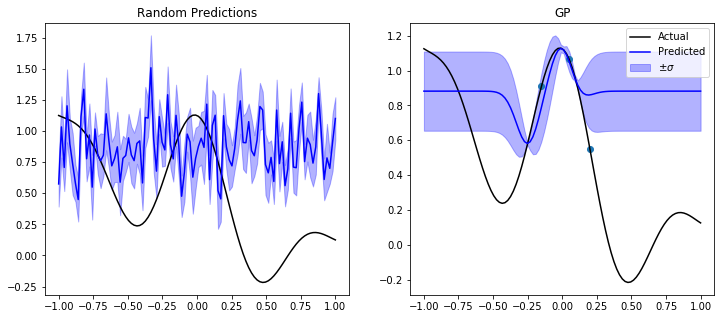

In [8]:
random_mean, random_var = random_model.predict(x_candidates, numpy=True)

pred_mean_v2, pred_var_v2 = model_v2.predict(x_candidates, numpy=True)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title("Random Predictions")
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, random_mean, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (random_mean + np.sqrt(random_var)).T[0], (random_mean - np.sqrt(random_var)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.subplot(122)
plt.title("GP")
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean_v2, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean_v2 + np.sqrt(pred_var_v2)).T[0], (pred_mean_v2 - np.sqrt(pred_var_v2)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.scatter(X_valid, Y_valid)

plt.legend()

plt.show()

# Test GP, GPAR and MF-GPAR implementations in 1-D

In [13]:
# Test function
def f(x):
    return np.sinc(3 * x[:, 0]).reshape(-1, 1)

# Set seed for reproducibility
np.random.seed(42)

# Generate input data
x_train = np.random.rand(8, 2) * 2 - 1
pseudo_point = np.array([[0.8, 0.3]])
x_train = np.vstack([x_train, pseudo_point])

y_train = f(x_train)

# Points for plotting
x_cont = np.arange(-1.5, 1.5, 0.02).reshape(-1, 1)
x_cont = np.hstack([x_cont, x_cont])

In [14]:
# FF-GP model
ff_gp = FullyFactorizedGPModel(kernel='rbf', 
                               input_dim=2, 
                               output_dim=1, 
                               verbose=False, 
                               initialization_heuristic="random")

ff_gp.fit(x_train, y_train, optimizer_restarts=5)
ff_gp = ff_gp.condition_on(x_train, y_train)

y_pred_ff_gp, var_pred_ff_gp = ff_gp.predict(x_cont, numpy=True)

20/03/2020 02:12:12 PM:INFO:boa.models.fully_factorized_gp:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
20/03/2020 02:12:12 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 1 / 5
20/03/2020 02:12:15 PM:INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 11.4006
20/03/2020 02:12:15 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 2 / 5
20/03/2020 02:12:17 PM:INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 11.4006
20/03/2020 02:12:17 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 3 / 5
20/03/2020 02:12:18 PM:INFO:boa.models.fully_factorized_gp:Loss for dimension 0: 11.4006
20/03/2020 02:12:18 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 4 / 5
20/03/2020 02:12:19 PM:INFO:boa.models.fully_factorized_gp:Loss for dimension 0: 11.4006
20/03/2020 02:12:19 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimizatio

In [18]:
ff_gp.models[0].log_pdf(x_train, y_train)

<tf.Tensor: shape=(), dtype=float64, numpy=-4.460004269646649>

In [21]:
# GPAR model
gpar = GPARModel(kernel='rbf', 
                 input_dim=2, 
                 output_dim=1, 
                 verbose=False, 
                 denoising=False,
                 initialization_heuristic="random")

gpar.fit(x_train, y_train, optimizer_restarts=5, optimizer="l-bfgs-b", trace=False, rate=1e-1)
gpar = gpar.condition_on(x_train, y_train)

y_pred_gpar, var_pred_gpar = gpar.predict(x_cont, numpy=True)

17/02/2020 01:31:09 PM:INFO:boa.models.gpar:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
17/02/2020 01:31:11 PM:INFO:boa.models.gpar:Output 0, Iteration 1: New best loss: 11.401
INFO:boa.models.gpar:Output 0, Iteration 1: New best loss: 11.401
17/02/2020 01:31:12 PM:INFO:boa.models.gpar:Output 0, Iteration 2: Loss: 12.770
INFO:boa.models.gpar:Output 0, Iteration 2: Loss: 12.770
17/02/2020 01:31:12 PM:INFO:boa.models.gpar:Output 0, Iteration 3: Loss: 12.770
INFO:boa.models.gpar:Output 0, Iteration 3: Loss: 12.770
17/02/2020 01:31:12 PM:INFO:boa.models.gpar:Output 0, Iteration 4: Loss: 12.770
INFO:boa.models.gpar:Output 0, Iteration 4: Loss: 12.770
17/02/2020 01:31:14 PM:INFO:boa.models.gpar:Output 0, Iteration 5: New best loss: 11.401
INFO:boa.models.gpar:Output 0, Iteration 5: New best loss: 11.401
17/02/2020 01:31:14 PM:INFO:boa.models.gpar:GPs haven't been cac

In [11]:
x_valid = np.random.rand(8, 2) * 2 - 1
y_valid = f(x_valid)

In [24]:
gpar.log_prob(x_valid, y_valid, use_conditioning_data=False)

<tf.Tensor: shape=(), dtype=float64, numpy=-8.883539994900934>

In [6]:
mf_gpar = MatrixFactorizedGPARModel(kernel='rbf', 
                                    latent_dim=1,
                                    input_dim=2, 
                                    output_dim=1, 
                                    verbose=True, 
                                    initialization_heuristic="median")

mf_gpar = mf_gpar.condition_on(x_train, y_train)
mf_gpar.fit_to_conditioning_data(optimizer_restarts=5, optimizer="l-bfgs-b", trace=True)

y_pred_mf_gpar, var_pred_mf_gpar = mf_gpar.predict(x_cont, numpy=True)

INFO:boa.models.matrix_factorized_gpar:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.matrix_factorized_gpar:-------------------------------
INFO:boa.models.matrix_factorized_gpar:Training iteration 1
INFO:boa.models.matrix_factorized_gpar:-------------------------------
DEBUG:boa.core.optimize:Optimizer evaluated the objective 60 times!
DEBUG:boa.core.optimize:Optimizer terminated after 20/200 iterations!
DEBUG:boa.core.optimize:Optimizer converged: True
DEBUG:boa.core.optimize:Optimizer diverged: False
INFO:boa.models.matrix_factorized_gpar:New best loss: 12.771
INFO:boa.models.matrix_factorized_gpar:-------------------------------
INFO:boa.models.matrix_factorized_gpar:Training iteration 2
INFO:boa.models.matrix_factorized_gpar:-------------------------------
DEBUG:boa.core.optimize:Optimizer evaluated the objective 161 times!
DEBUG:boa.core.optimize:Optimizer terminated after 62/200 iterations!
DEBUG:boa.core.optimize:Optimizer converged:

In [7]:
pgpar = PermutedGPARModel(kernel='rbf', 
                         input_dim=2, 
                         output_dim=1, 
                         verbose=False, 
                         denoising=False,
                         initialization_heuristic="random")

pgpar.fit(x_train, y_train, optimizer_restarts=5, learn_rate=1e-1, iters=1000, use_bfgs=True)
pgpar = pgpar.condition_on(x_train, y_train)

y_pred_pgpar, var_pred_pgpar = pgpar.predict(x_cont, numpy=True)

INFO:boa.models.gpar_perm:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar_perm:Output 0, Iteration 1: New best loss: 11.401
INFO:boa.models.gpar_perm:Output 0, Iteration 2: Loss: 12.770
INFO:boa.models.gpar_perm:Output 0, Iteration 3: New best loss: 11.401
INFO:boa.models.gpar_perm:Output 0, Iteration 4: New best loss: 11.401
ERROR:boa.models.gpar_perm:Model diverged, restarting iteration 5!
INFO:boa.models.gpar_perm:Output 0, Iteration 4: Loss: 12.766
INFO:boa.models.gpar_perm:Output 0, Iteration 5: Loss: 12.770
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


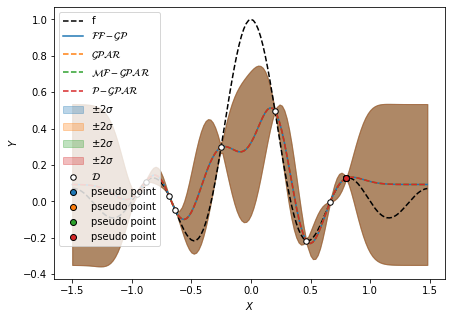

In [8]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Ground truth
ax.plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax.plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax.fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax.plot(x_cont[:, 0], y_pred_gpar, color='C1', zorder=-1, label=r'$\mathcal{GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# # # MF-GPAR predictions
ax.plot(x_cont[:, 0], y_pred_mf_gpar, color='C2', zorder=-1, label=r'$\mathcal{MF-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_mf_gpar + 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                (y_pred_mf_gpar - 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                color='C2',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# PGPAR predictions
ax.plot(x_cont[:, 0], y_pred_pgpar, color='C3', zorder=-1, label=r'$\mathcal{P-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_pgpar + 2 * np.sqrt(var_pred_pgpar)).T[0],
                (y_pred_pgpar - 2 * np.sqrt(var_pred_pgpar)).T[0],
                color='C3',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Data points
ax.scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax.scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=mf_gpar.predict(pseudo_point)[0][0], c='C2', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=pgpar.predict(pseudo_point)[0][0], c='C3', edgecolors='black', label='pseudo point')

ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

fig.show()

# Test saving

In [30]:
ff_gp_save_path = "models/ff_gp/gp1"

ff_gp.save(ff_gp_save_path)

ff_gp_ = FullyFactorizedGPModel.restore(ff_gp_save_path)

y_pred_ff_gp_, var_pred_ff_gp_ = ff_gp_.predict(x_cont)

y_pred_ff_gp_ = y_pred_ff_gp_.numpy()
var_pred_ff_gp_ = var_pred_ff_gp_.numpy()

gpar_save_path = "models/gpar/gp1"

gpar.save(gpar_save_path)

gpar_ = GPARModel.restore(gpar_save_path)

y_pred_gpar_, var_pred_gpar_ = gpar_.predict(x_cont)

y_pred_gpar_ = y_pred_gpar_.numpy()
var_pred_gpar_ = var_pred_gpar_.numpy()

DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True


DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


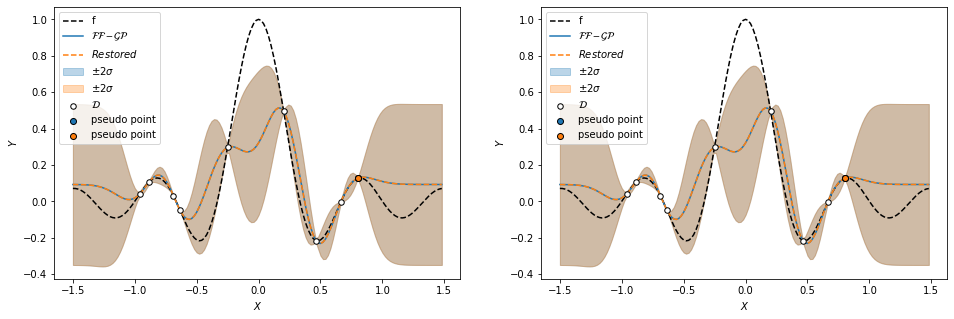

In [31]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Ground truth
ax[0].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Restored predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp_ + 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                (y_pred_ff_gp_ - 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[0].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[0].legend(loc='upper left')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

# Ground truth
ax[1].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar_ + 2 * np.sqrt(var_pred_gpar_)).T[0],
                (y_pred_gpar_ - 2 * np.sqrt(var_pred_gpar_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[1].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[1].legend(loc='upper left')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('$Y$')

fig.show()

# MF-GPAR performance test

# Discrete-kernel GP Test

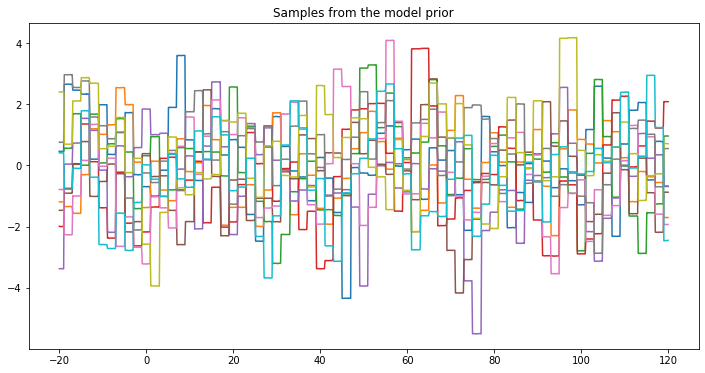

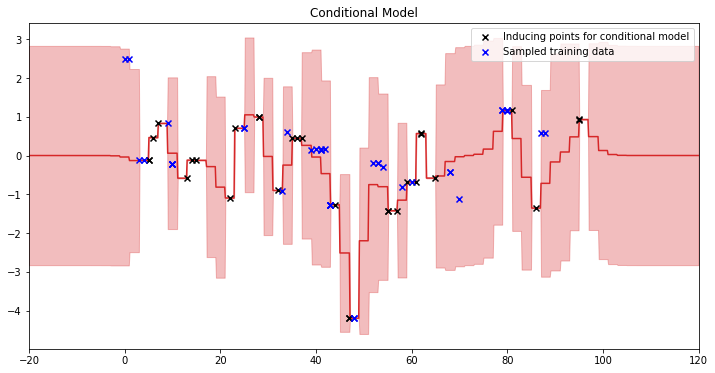

In [195]:
tf.random.set_seed(42)

alpha = 2.
length_scale = 2.
noise = 1e-5

kern = alpha * DiscreteMatern52().stretch(length_scale)
noise_kern = noise * Delta()

signal_gp = GP(kern)
noise_gp = GP(noise_kern)

model = signal_gp + noise_gp

# Generate some data from out model

xs = tf.cast(tf.linspace(-20., 120., 1000), dtype=tf.float32)

plt.figure(figsize=(12, 6))
plt.title("Samples from the model prior")
plt.plot(xs, model(xs).sample(10))
plt.show()

# Pick a random function as our mean
# Random input points
int_xs = tf.random.categorical(logits=5. * tf.random.uniform(shape=(1, 100)),
                               num_samples=30)

int_xs = tf.cast(int_xs, tf.float32)[0]

ys = model(int_xs).sample()[:, 0]

# Condition model on dummy data
cond_model = model | (int_xs, ys)

cond_mean = cond_model(xs).mean.numpy()
cond_var = cond_model.kernel.elwise(xs).numpy()


# Sample from the conditional model
cond_logits = 5. * tf.random.uniform(shape=(1, 100))

# The datapoints we sampled should have 0 probability of being sampled
cond_logits = tf.tensor_scatter_nd_update(cond_logits[0], 
                                          tf.cast(int_xs, tf.int32)[:, None], 
                                          -np.inf * tf.ones_like(int_xs))[None, :]

train_int_xs = tf.random.categorical(logits=cond_logits,
                               num_samples=40)

train_int_xs = tf.cast(train_int_xs, tf.float32)[0]

train_int_ys = cond_model(train_int_xs).sample()

plt.figure(figsize=(12, 6))
plt.title("Conditional Model")
plt.plot(xs, cond_mean, color='C3', zorder=-1,)
plt.fill_between(xs.numpy(),
                (cond_mean + 2 * np.sqrt(cond_var)).T[0],
                (cond_mean - 2 * np.sqrt(cond_var)).T[0],
                color='C3',
                alpha=0.3,
                zorder=-1)
plt.scatter(int_xs, 
            ys,
            marker='x',
            c='k',
            label="Inducing points for conditional model")

plt.scatter(train_int_xs, 
            train_int_ys,
            marker='x',
            c='b',
            label="Sampled training data")
plt.legend()
plt.xlim(-20, 120)
plt.show()